#  2019 Oscar Best Picture Movie Nomination Prediction 

##  Data Sets: The Movie DB API and Oscar Winning Data (1934-2015) 


### Part 1: Movie Data Exploratory Data Analysis


In [2]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter # to format currency on charts axis

from wordcloud import WordCloud

from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression 
from sklearn import ensemble 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import brier_score_loss, precision_score, recall_score,f1_score, roc_auc_score, accuracy_score 
from sklearn.metrics import confusion_matrix, roc_curve,auc
#from sklearn.cross_validation import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.feature_extraction import DictVectorizer
from sklearn.cluster import KMeans

from sklearn.feature_selection import RFE

import random

from scipy.stats import ttest_ind
import scipy

In [3]:
import numpy as np
import pandas as pd

import requests 
import json
from pprint import pprint


## TMDB 5000 Movies Data EDA

In [4]:
tmdb_orig_db = pd.read_csv('./DataSources/tmdb_5000_movies.csv')

oscar_movie_db = pd.read_csv('./DataSources/Oscars1934-2015.csv')
oscar_movie_db.head()

,Year,Ceremony,Award,Winner,Name,Film
0,1934,7,Actor,1,Clark Gable,It Happened One Night
1,1934,7,Actor,0,Frank Morgan,The Affairs of Cellini
2,1934,7,Actor,0,William Powell,The Thin Man
3,1934,7,Actress,1,Claudette Colbert,It Happened One Night
4,1934,7,Actress,0,Bette Davis,Of Human Bondage


In [5]:
oscar_movie_db['Award'].value_counts()

Film Editing                                                                                                                                 410
Directing                                                                                                                                    407
Actress in a Supporting Role                                                                                                                 400
Actor in a Supporting Role                                                                                                                   400
Documentary (Short Subject)                                                                                                                  348
Documentary (Feature)                                                                                                                        315
Foreign Language Film                                                                                                             

In [6]:
tmdb_orig_db.count()

budget                  4803
genres                  4803
homepage                1712
id                      4803
keywords                4803
original_language       4803
original_title          4803
overview                4800
popularity              4803
production_companies    4803
production_countries    4803
release_date            4802
revenue                 4803
runtime                 4801
spoken_languages        4803
status                  4803
tagline                 3959
title                   4803
vote_average            4803
vote_count              4803
dtype: int64

In [7]:
columns = ['id','title','budget','revenue','vote_average','runtime','vote_count','popularity','release_date','keywords','genres']


tmdb_movie_info_df = tmdb_orig_db[columns]



In [8]:
tmdb_movie_info_df = tmdb_movie_info_df.dropna()

In [9]:
tmdb_movie_info_df['release_month'] = pd.DatetimeIndex(tmdb_movie_info_df['release_date']).month

tmdb_movie_info_df.release_month = tmdb_movie_info_df.release_month.astype(int)




In [10]:
tmdb_movie_info_df = tmdb_movie_info_df.drop(columns = ['release_date'])
tmdb_movie_info_df.head()

,id,title,budget,revenue,vote_average,runtime,vote_count,popularity,keywords,genres,release_month
0,19995,Avatar,237000000,2787965087,7.2,162.0,11800,150.437577,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",12
1,285,Pirates of the Caribbean: At World's End,300000000,961000000,6.9,169.0,4500,139.082615,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",5
2,206647,Spectre,245000000,880674609,6.3,148.0,4466,107.376788,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",10
3,49026,The Dark Knight Rises,250000000,1084939099,7.6,165.0,9106,112.312950,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",7
4,49529,John Carter,260000000,284139100,6.1,132.0,2124,43.926995,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",3


In [11]:
tmdb_movie_info_df['keywords']=tmdb_movie_info_df['keywords'].apply(json.loads)
tmdb_movie_info_df['genres']=tmdb_movie_info_df['genres'].apply(json.loads)

## Analysis TMDB 5000 movies' Keywords and Genres

In [12]:
def get_names(keywords):
    return '|'.join([x['name'] for x in keywords]) 

# Format genres and keywords dictionary into string
tmdb_movie_info_df['genres'] = tmdb_movie_info_df['genres'].apply(get_names)
tmdb_movie_info_df['keywords'] = tmdb_movie_info_df['keywords'].apply(get_names)

In [13]:
tmdb_movie_info_df.head()

,id,title,budget,revenue,vote_average,runtime,vote_count,popularity,keywords,genres,release_month
0,19995,Avatar,237000000,2787965087,7.2,162.0,11800,150.437577,culture clash|future|space war|space colony|so...,Action|Adventure|Fantasy|Science Fiction,12
1,285,Pirates of the Caribbean: At World's End,300000000,961000000,6.9,169.0,4500,139.082615,ocean|drug abuse|exotic island|east india trad...,Adventure|Fantasy|Action,5
2,206647,Spectre,245000000,880674609,6.3,148.0,4466,107.376788,spy|based on novel|secret agent|sequel|mi6|bri...,Action|Adventure|Crime,10
3,49026,The Dark Knight Rises,250000000,1084939099,7.6,165.0,9106,112.312950,dc comics|crime fighter|terrorist|secret ident...,Action|Crime|Drama|Thriller,7
4,49529,John Carter,260000000,284139100,6.1,132.0,2124,43.926995,based on novel|mars|medallion|space travel|pri...,Action|Adventure|Science Fiction,3


In [14]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: 
        keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1

    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [15]:
def keys_set(df,col_name):
    keys = set()
    for keyword in df[col_name].str.split('|').values:
        if isinstance(keyword, float): continue  # only happen if liste_keywords = NaN
        keys = keys.union(keyword)
    keys.remove('')
    return keys

keywords_set = keys_set(tmdb_movie_info_df,'keywords')
keyword_occurences, dum = count_word(tmdb_movie_info_df, 'keywords', keywords_set)
keyword_occurences[:5]



[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 189]]

In [16]:
genres_set = keys_set(tmdb_movie_info_df,'genres')

In [17]:
genres_set

{'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western'}

In [18]:
#genre_labels = set()
#for s in tmdb_movie_info_df['genres'].str.split('|').values:
#    genre_labels = genre_labels.union(set(s))
 

genres_occurences,dum = count_word(tmdb_movie_info_df, 'genres', genres_set)
genres_occurences[:5]

[['Drama', 2296],
 ['Comedy', 1722],
 ['Thriller', 1274],
 ['Action', 1154],
 ['Romance', 894]]

In [19]:
genre_sets = keys_set(tmdb_movie_info_df,'genres')
genres_occurences = count_word(tmdb_movie_info_df, 'genres', genre_sets)

In [20]:
genres_occurences

([['Drama', 2296],
  ['Comedy', 1722],
  ['Thriller', 1274],
  ['Action', 1154],
  ['Romance', 894],
  ['Adventure', 790],
  ['Crime', 696],
  ['Science Fiction', 535],
  ['Horror', 519],
  ['Family', 513],
  ['Fantasy', 424],
  ['Mystery', 348],
  ['Animation', 234],
  ['History', 197],
  ['Music', 185],
  ['War', 144],
  ['Documentary', 109],
  ['Western', 82],
  ['Foreign', 34],
  ['TV Movie', 8]],
 {'Adventure': 790,
  'Music': 185,
  'Crime': 696,
  'Action': 1154,
  'Thriller': 1274,
  'Western': 82,
  'Documentary': 109,
  'TV Movie': 8,
  'Drama': 2296,
  'History': 197,
  'Animation': 234,
  'Family': 513,
  'Science Fiction': 535,
  'Comedy': 1722,
  'Fantasy': 424,
  'Horror': 519,
  'War': 144,
  'Romance': 894,
  'Foreign': 34,
  'Mystery': 348})

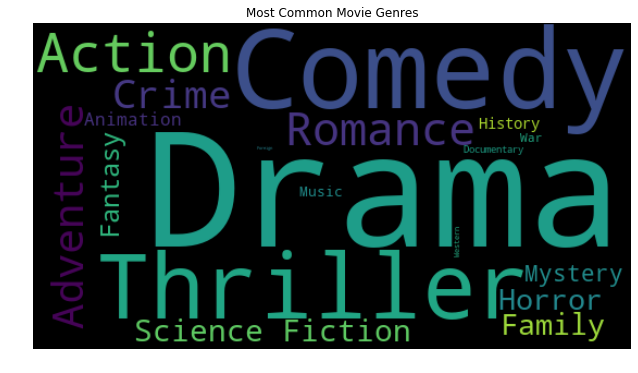

In [21]:
words = dict()
trunc_occurences = genres_occurences[0]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='black', 
                      max_words=1628,relative_scaling=0.7,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Most Common Movie Genres')

plt.show()

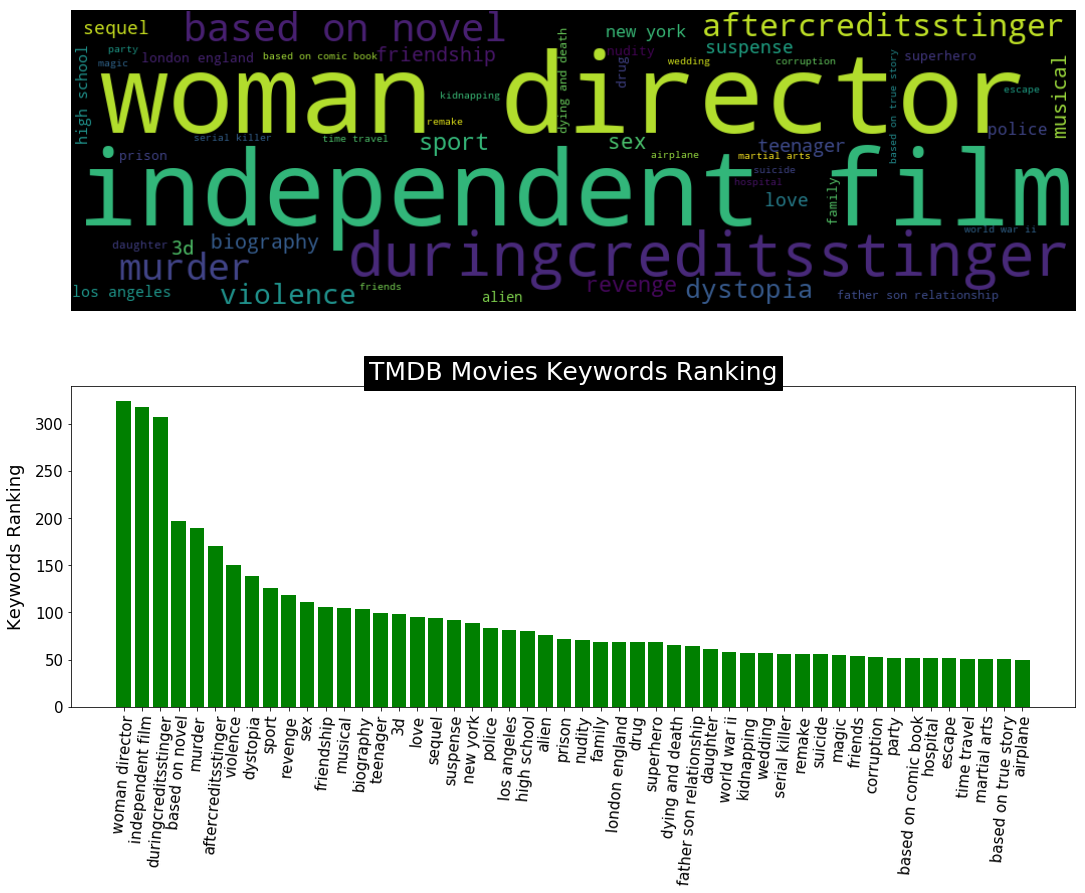

In [22]:
# KEYWORDS WORDCLOUD
fig = plt.figure(1, figsize=(18,13))
ax1 = fig.add_subplot(2,1,1)

words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 55.0 # define the color of the words


wordcloud = WordCloud(width=1000,height=300, background_color='black', 
                      max_words=1628,relative_scaling=1,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis('off')

# HISTOGRAMS
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("Keywords Ranking", fontsize = 18, labelpad = 10)
ax2.bar(x_axis, y_axis, align = 'center', color='g')

plt.title("TMDB Movies Keywords Ranking",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 25)
fig.savefig('mostkeywords.png')
plt.show()

## 1934 - 2015 Oscar Winning Movies Data Analysis

In [24]:
best_pictures_df = oscar_movie_db[((oscar_movie_db['Award']== 'Best Picture')|(oscar_movie_db['Award']== 'Best Motion Picture'))]
best_pictures_df = best_pictures_df.rename(columns = {'Name' : 'title','Film' : 'production'})
best_pictures_df.head()

,Year,Ceremony,Award,Winner,title,production
1486,1944,17,Best Motion Picture,0,Double Indemnity,Paramount
1487,1944,17,Best Motion Picture,0,Gaslight,Metro-Goldwyn-Mayer
1488,1944,17,Best Motion Picture,1,Going My Way,Paramount
1489,1944,17,Best Motion Picture,0,Since You Went Away,Selznick International Pictures
1490,1944,17,Best Motion Picture,0,Wilson,20th Century-Fox


In [25]:
# Check the movie title value counts
best_pictures_df['title'].value_counts()


Moulin Rouge                                        2
Atlantic City                                       1
No Country for Old Men                              1
Black Swan                                          1
The Deer Hunter                                     1
Juno                                                1
Apollo 13                                           1
Barry Lyndon                                        1
The Last Picture Show                               1
Room at the Top                                     1
The Goodbye Girl                                    1
Born Yesterday                                      1
Lawrence of Arabia                                  1
Quo Vadis                                           1
Breaking Away                                       1
Tender Mercies                                      1
The Revenant                                        1
Toy Story 3                                         1
True Grit                   

In [26]:
# There are two nominations with the same name ('Moulin Rouge' )
repeat_movies = best_pictures_df.loc[best_pictures_df['title'] == 'Moulin Rouge ']
repeat_movies_year = list(repeat_movies['Year'])

In [27]:
repeat_movies

,Year,Ceremony,Award,Winner,title,production
2447,1952,25,Best Motion Picture,0,Moulin Rouge,Romulus Films
7975,2001,74,Best Picture,0,Moulin Rouge,"Martin Brown, Baz Luhrmann and Fred Baron, Pro..."


In [28]:
len(best_pictures_df)

388

In [29]:
best_pictures_df = best_pictures_df[best_pictures_df['title']!='Moulin Rouge ']

### The following three movies has no detailed movie information via TDMB API calls

In [30]:
# Drop the qurey error movies due to wrong movie name
best_pictures_df = best_pictures_df[best_pictures_df['title']!="Meredith Willson's The Music Man "]

In [31]:
best_pictures_df = best_pictures_df[best_pictures_df['title']!='Cries and Whispers ']

In [32]:
best_pictures_df = best_pictures_df[best_pictures_df['title']!='Good Fellas ']

In [33]:
len(best_pictures_df)

383

In [34]:
winner_film_name = list(best_pictures_df['title'])

In [35]:
len(winner_film_name)

383

## Oscar Best Picture/Motion Picture Data Query via TMDB api

In [36]:
# use api.tmdb.org due to problem of 'query limit is 40'
base_url ='https://api.tmdb.org/3/search/movie?'
#base_url ='https://api.themoviedb.org/3/search/movie?'
api_key = 'api_key=d5b4e5d5145be601d4640d76efd791e3'
query = '&query='
query_base_url = base_url + api_key + query

# best_pic_info: get the movie summary information 
best_pic_info = []

# There are two nominations with the same name ('Moulin Rouge' )
for i in range(len(winner_film_name)):     
        print(i,winner_film_name[i])
        release_year = best_pictures_df.loc[best_pictures_df['title'] == winner_film_name[i],'Year'].item()
        movie_info = query_base_url + winner_film_name[i] + '&year=' + str(release_year)
        response=requests.get(movie_info).json()
        best_pic_info.append(response['results'])

best_pic_info_1 = best_pic_info

0 Double Indemnity 
1 Gaslight 
2 Going My Way 
3 Since You Went Away 
4 Wilson 
5 Anchors Aweigh 
6 The Bells of St. Mary's 
7 The Lost Weekend 
8 Mildred Pierce 
9 Spellbound 
10 The Best Years of Our Lives 
11 Henry V 
12 It's a Wonderful Life 
13 The Razor's Edge 
14 The Yearling 
15 The Bishop's Wife 
16 Crossfire 
17 Gentleman's Agreement 
18 Great Expectations 
19 Miracle on 34th Street 
20 Hamlet 
21 Johnny Belinda 
22 The Red Shoes 
23 The Snake Pit 
24 The Treasure of the Sierra Madre 
25 All the King's Men 
26 Battleground 
27 The Heiress 
28 A Letter to Three Wives 
29 Twelve O'Clock High 
30 All about Eve 
31 Born Yesterday 
32 Father of the Bride 
33 King Solomon's Mines 
34 Sunset Blvd. 
35 An American in Paris 
36 Decision before Dawn 
37 A Place in the Sun 
38 Quo Vadis 
39 A Streetcar Named Desire 
40 The Greatest Show on Earth 
41 High Noon 
42 Ivanhoe 
43 The Quiet Man 
44 From Here to Eternity 
45 Julius Caesar 
46 The Robe 
47 Roman Holiday 
48 Shane 
49 The Caine

In [37]:
repeat_movies_info = []
for i in range(len(repeat_movies_year)):
    release_year = str(repeat_movies_year[i])
    movie_info = query_base_url + 'Moulin Rouge ' + '&year=' + str(release_year)
    response=requests.get(movie_info).json()
    #best_pic_info.append(response['results'])
    repeat_movies_info.append(response['results'])

In [38]:
base_url1 = 'https://api.tmdb.org/3/movie/'

#language = '&language=en-US'
keyword = '/keywords?'
Winner_Details= []
keyword_details = []
tmdb_id_list = []
#keywords: https://api.themoviedb.org/3/movie/23383/keywords?api_key=d5b4e5d5145be601d4640d76efd791e3

no_info_list =[]

for i in range(len(best_pic_info)):
    #print(i) debugging for query errors
    try:
        tmdb_id = str(best_pic_info[i][0]['id'])
    except:
        no_info_list.append(i)
        print('No info in TMDB',i)
        continue
    tmdb_id_list.append(best_pic_info[i][0]['id'])
    detail_query_link = base_url1 + tmdb_id + '?' + api_key #+ language
    keywords_query_link = base_url1 + tmdb_id + keyword + api_key
    #print(detail_query_link)
    #print(keywords_query_link)
    response = requests.get(detail_query_link).json()
    keywords_response = requests.get(keywords_query_link).json()
    Winner_Details.append(response)
    keyword_details.append(keywords_response)

In [39]:
no_info_list

[]

In [40]:
keyword_details

[{'id': 996,
  'keywords': [{'id': 236, 'name': 'suicide'},
   {'id': 3973, 'name': 'insurance salesman'},
   {'id': 4617, 'name': 'insurance fraud'},
   {'id': 4618, 'name': 'step daughter'},
   {'id': 4619, 'name': 'train accident'},
   {'id': 6038, 'name': 'marriage'},
   {'id': 9016, 'name': 'femme fatale'},
   {'id': 9826, 'name': 'murder'},
   {'id': 33456, 'name': 'double cross'},
   {'id': 155436, 'name': 'classic noir'},
   {'id': 195402, 'name': 'film noir'}]},
 {'id': 13528,
  'keywords': [{'id': 131, 'name': 'italy'},
   {'id': 770, 'name': 'scotland yard'},
   {'id': 3344, 'name': 'letter'},
   {'id': 6894, 'name': 'aunt'},
   {'id': 8250, 'name': 'victorian england'},
   {'id': 9826, 'name': 'murder'},
   {'id': 9937, 'name': 'suspense'},
   {'id': 14743, 'name': 'pianist'},
   {'id': 15274, 'name': 'nervous breakdown'},
   {'id': 191476, 'name': 'driven mad'}]},
 {'id': 17661, 'keywords': [{'id': 10093, 'name': 'priest'}]},
 {'id': 42401,
  'keywords': [{'id': 6623, 'nam

In [41]:
winning_keywords = []
keywords_list = []

for i in range(len(keyword_details)):
    for j in range(len(keyword_details[i]['keywords'])):
        winning_keywords.append(keyword_details[i]['keywords'][j]['name'])
    keywords_list.append(keyword_details[i]['keywords'])

   
    

In [42]:
winning_keywords

['suicide',
 'insurance salesman',
 'insurance fraud',
 'step daughter',
 'train accident',
 'marriage',
 'femme fatale',
 'murder',
 'double cross',
 'classic noir',
 'film noir',
 'italy',
 'scotland yard',
 'letter',
 'aunt',
 'victorian england',
 'murder',
 'suspense',
 'pianist',
 'nervous breakdown',
 'driven mad',
 'priest',
 'lodger',
 'love',
 'teenage girl',
 'war effort',
 'homefront',
 'rationing',
 'biography',
 'historical figure',
 'musical',
 'new york city',
 'cartoon mouse',
 'live action and animation',
 'nun',
 'priest',
 'school',
 'church',
 'catholic',
 'desperation',
 'paranoia',
 'weekend',
 'bartender',
 'brother',
 'addiction',
 'alcoholism',
 'suicidal',
 'writer',
 'alcoholic',
 'bats',
 'low self esteem',
 'flashback',
 'dishonesty',
 'film noir',
 'hopelessness',
 'delirium tremens',
 'lies',
 'evasion',
 'devoted girlfriend',
 'wife husband relationship',
 'infidelity',
 'restaurant',
 'snob',
 'business woman',
 'daughter',
 'promise',
 'spoiled child'

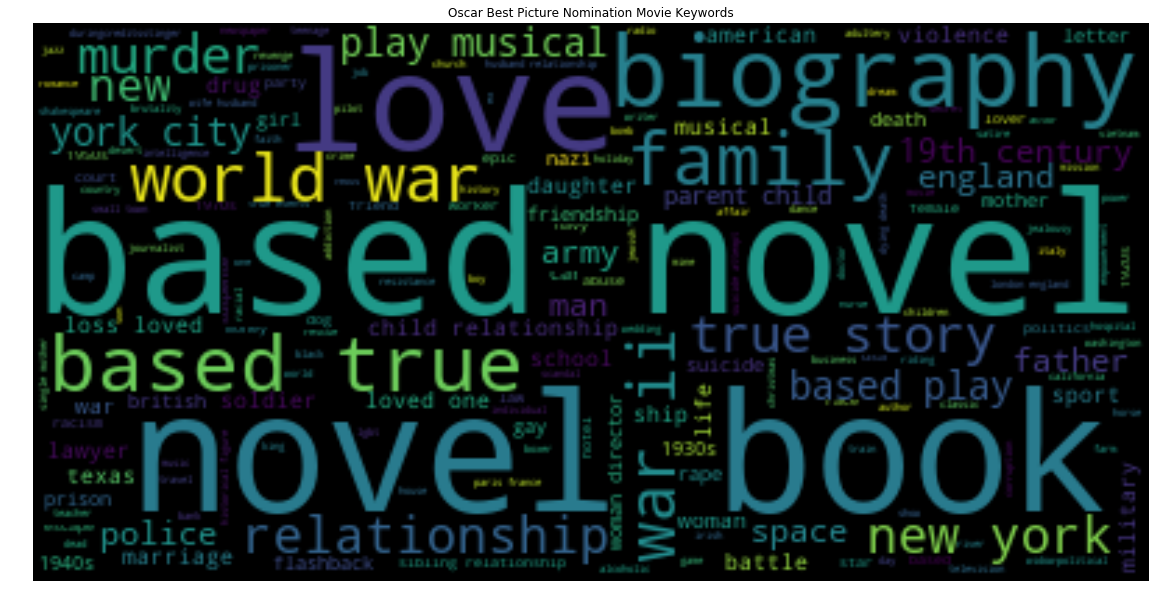

In [277]:


wc = WordCloud(background_color="white", max_words=1000,contour_width=3, contour_color='steelblue')



text = ' '.join(winning_keywords)
# Generate a word cloud image
#wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(max_words=1000).generate(text)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Oscar Best Picture Nomination Movie Keywords')
fig.savefig('bestpic_keywords.png')


## Build Movie Features Data set

In [44]:
revenue_list = []
budget_list = []
runtime_list = []
vote_average_list = []
vote_count_list =[]
pop_list = []
genre_list =[]
release_date_list = []


for i in range(len(Winner_Details)):
    revenue_list.append(Winner_Details[i]['revenue'])
    budget_list.append(Winner_Details[i]['budget'])
    runtime_list.append(Winner_Details[i]['runtime'])
    vote_average_list.append(Winner_Details[i]['vote_average'])
    vote_count_list.append(Winner_Details[i]['vote_count'])
    pop_list.append(Winner_Details[i]['popularity'])
    genre_list.append(Winner_Details[i]['genres'])
    release_date_list.append(Winner_Details[i]['release_date'])
    


In [45]:
release_month_list = []
for i in range(len(release_date_list)):
    release_month = release_date_list[i].split('-')
    release_month_list.append(release_month[1])
        

In [46]:
best_pictures_df['id'] = pd.Series(tmdb_id_list).values
best_pictures_df['revenue'] = pd.Series(revenue_list).values
best_pictures_df['budget'] =  pd.Series(budget_list).values
best_pictures_df['runtime'] = pd.Series(runtime_list).values
best_pictures_df['vote_average'] = pd.Series(vote_average_list).values
best_pictures_df['vote_count'] = pd.Series(vote_count_list).values
best_pictures_df['popularity'] = pd.Series(pop_list).values
best_pictures_df['genres'] = pd.Series(genre_list).values
best_pictures_df['release_month'] = pd.Series(release_month_list).values
best_pictures_df['keywords'] = pd.Series(keywords_list).values

In [47]:
best_pictures_df.dtypes

Year               int64
Ceremony           int64
Award             object
Winner             int64
title             object
production        object
id                 int64
revenue            int64
budget             int64
runtime            int64
vote_average     float64
vote_count         int64
popularity       float64
genres            object
release_month     object
keywords          object
dtype: object

# Oscar Best Picture/Motion picture Movie Analysis

## 1. Genre and Release Month Analysis

In [48]:
genre_list = list(best_pictures_df['genres'])

winning_genre = []
for i in range(len(genre_list)):
    for j in range(len(genre_list[i])):
        winning_genre.append(genre_list[i][j]['name'])
    

winning_genre_df = pd.DataFrame({'genres':winning_genre})
winning_genre_counts = winning_genre_df['genres'].value_counts()

winning_genre_counts = winning_genre_counts.rename_axis('genres').reset_index(name = 'counts')

In [49]:
winning_genre_counts

,genres,counts
0,Drama,341
1,Romance,115
2,Comedy,76
3,History,63
4,Thriller,57
5,Crime,47
6,Adventure,43
7,War,41
8,Action,35
9,Mystery,23


In [50]:
winning_month_count = best_pictures_df.groupby('release_month')['Award'].count()

In [51]:
winning_month_count_df = winning_month_count.to_frame()

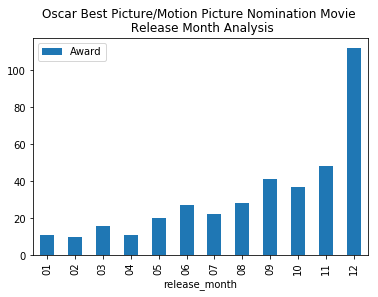

In [52]:
# Only focus on the Best Picture Category
winning_month_count_df.plot(kind = 'bar',title = 'Oscar Best Picture/Motion Picture Nomination Movie \n Release Month Analysis')


<Figure size 1440x1440 with 0 Axes>

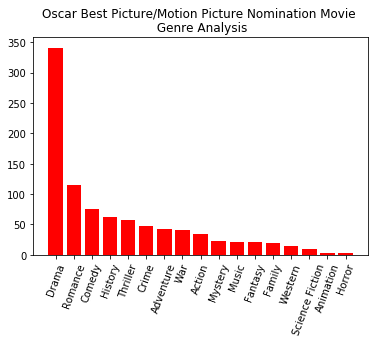

In [53]:
plt.figure(figsize=(20,20))
fig, ax = plt.subplots()


plt.bar(winning_genre_counts['genres'],winning_genre_counts['counts'],color = 'red')
plt.title('Oscar Best Picture/Motion Picture Nomination Movie \n Genre Analysis')
plt.xticks(rotation=70)
fig.savefig('bestpic_genre.png')


## 2. Oscar Best Picture/Motion Films Revenues/Budgets Analysis

<Figure size 1440x1440 with 0 Axes>

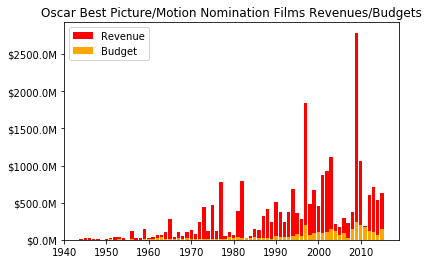

In [54]:


def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x*1e-6)
formatter = FuncFormatter(millions)

plt.figure(figsize=(20,20))
fig, ax = plt.subplots()


p1 = plt.bar(best_pictures_df['Year'],best_pictures_df['revenue'],color = 'red')

p2 = plt.bar(best_pictures_df['Year'],best_pictures_df['budget'], color = 'orange')

ax.yaxis.set_major_formatter(formatter)
plt.title('Oscar Best Picture/Motion Nomination Films Revenues/Budgets')
plt.legend((p1[0],p2[0]),('Revenue','Budget'))
fig.savefig('best_rev.png')
plt.show()


# 3. Oscar Best Picture/Motion Films Vote/Popularity Analysis

<Figure size 1440x14400 with 0 Axes>

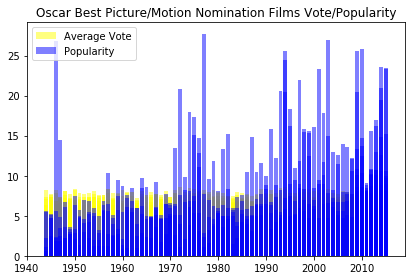

In [55]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker


plt.figure(figsize=(20,200))
fig, ax = plt.subplots()
bar_width =0.8 
p1 = plt.bar(best_pictures_df['Year'],best_pictures_df['vote_average'],bar_width,color = 'yellow',alpha=0.5)

p2 = plt.bar(best_pictures_df['Year'],best_pictures_df['popularity'],bar_width,color = 'blue',alpha=0.5)



plt.title('Oscar Best Picture/Motion Nomination Films Vote/Popularity')
plt.legend((p1[0],p2[0]),('Average Vote','Popularity'))

plt.tight_layout()
fig.savefig('best_pop.png')
plt.show()

## Oscar Best Picture Feature Enginerring

### - Build Training Data


In [56]:


new_col = ['id','title','budget','revenue','vote_average','runtime','vote_count','popularity','release_month','keywords','genres']


best_pic_label_df = best_pictures_df[new_col]


In [57]:
best_pic_label_df.release_month = best_pic_label_df.release_month.astype(int)

best_pic_label_df['keywords'] = best_pic_label_df['keywords'].apply(get_names)
best_pic_label_df['genres'] = best_pic_label_df['genres'].apply(get_names)

best_pic_label_df.head()

/Users/my_macbook/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,id,title,budget,revenue,vote_average,runtime,vote_count,popularity,release_month,keywords,genres
1486,996,Double Indemnity,927262,2500000,8.2,107,644,5.584,4,suicide|insurance salesman|insurance fraud|ste...,Crime|Drama|Mystery|Thriller
1487,13528,Gaslight,2068000,0,7.4,114,118,5.506,5,italy|scotland yard|letter|aunt|victorian engl...,Drama|Mystery|Thriller|Crime
1488,17661,Going My Way,0,16300000,7.1,130,51,2.164,5,priest,Drama|Comedy|Music
1489,42401,Since You Went Away,0,0,6.3,172,10,1.059,7,lodger|love|teenage girl|war effort|homefront|...,Drama|Romance|War
1490,84084,Wilson,2995000,2000000,5.5,154,6,0.600,8,biography|historical figure,Romance|Drama|History|Music


In [58]:
ind = 0

for i in range(len(tmdb_id_list)):
    ind = tmdb_movie_info_df.loc[tmdb_movie_info_df['id']==tmdb_id_list[i]].index.values.astype(int)
    if np.isnan(ind) == False:
        tmdb_movie_info_df = tmdb_movie_info_df.drop(ind, axis =0)
    

/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  """


In [59]:
tmdb_movie_info_df.count()

id               4573
title            4573
budget           4573
revenue          4573
vote_average     4573
runtime          4573
vote_count       4573
popularity       4573
keywords         4573
genres           4573
release_month    4573
dtype: int64

In [60]:
tmdb_movie_info_df['nominated'] =0

In [61]:
tmdb_movie_info_df.head()

,id,title,budget,revenue,vote_average,runtime,vote_count,popularity,keywords,genres,release_month,nominated
1,285,Pirates of the Caribbean: At World's End,300000000,961000000,6.9,169.0,4500,139.082615,ocean|drug abuse|exotic island|east india trad...,Adventure|Fantasy|Action,5,0
2,206647,Spectre,245000000,880674609,6.3,148.0,4466,107.376788,spy|based on novel|secret agent|sequel|mi6|bri...,Action|Adventure|Crime,10,0
3,49026,The Dark Knight Rises,250000000,1084939099,7.6,165.0,9106,112.312950,dc comics|crime fighter|terrorist|secret ident...,Action|Crime|Drama|Thriller,7,0
4,49529,John Carter,260000000,284139100,6.1,132.0,2124,43.926995,based on novel|mars|medallion|space travel|pri...,Action|Adventure|Science Fiction,3,0
5,559,Spider-Man 3,258000000,890871626,5.9,139.0,3576,115.699814,dual identity|amnesia|sandstorm|love of one's ...,Fantasy|Action|Adventure,5,0


In [62]:
best_pic_label_df['nominated'] = 1




/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Genre Features - Winning Weight

In [63]:

winning_genre_counts['weight'] = winning_genre_counts['counts']/winning_genre_counts['counts'].sum()


In [64]:
winning_genre_counts

,genres,counts,weight
0,Drama,341,0.365880
1,Romance,115,0.123391
2,Comedy,76,0.081545
3,History,63,0.067597
4,Thriller,57,0.061159
5,Crime,47,0.050429
6,Adventure,43,0.046137
7,War,41,0.043991
8,Action,35,0.037554
9,Mystery,23,0.024678


In [65]:
gname = list(winning_genre_counts['genres'])
gweight = list(winning_genre_counts['weight'])             



In [66]:
gname

['Drama',
 'Romance',
 'Comedy',
 'History',
 'Thriller',
 'Crime',
 'Adventure',
 'War',
 'Action',
 'Mystery',
 'Music',
 'Fantasy',
 'Family',
 'Western',
 'Science Fiction',
 'Animation',
 'Horror']

In [67]:
genre_weight_dict = dict(zip(gname,gweight))
genre_weight_dict

{'Drama': 0.36587982832618027,
 'Romance': 0.12339055793991416,
 'Comedy': 0.0815450643776824,
 'History': 0.06759656652360516,
 'Thriller': 0.0611587982832618,
 'Crime': 0.05042918454935622,
 'Adventure': 0.046137339055793994,
 'War': 0.043991416309012876,
 'Action': 0.03755364806866953,
 'Mystery': 0.02467811158798283,
 'Music': 0.022532188841201718,
 'Fantasy': 0.022532188841201718,
 'Family': 0.0203862660944206,
 'Western': 0.015021459227467811,
 'Science Fiction': 0.01072961373390558,
 'Animation': 0.003218884120171674,
 'Horror': 0.003218884120171674}

In [68]:
mean_weight = sum(gweight)/len(gweight)
genre_weight_dict.update({'other':mean_weight})

In [69]:
genre_weight_dict

{'Drama': 0.36587982832618027,
 'Romance': 0.12339055793991416,
 'Comedy': 0.0815450643776824,
 'History': 0.06759656652360516,
 'Thriller': 0.0611587982832618,
 'Crime': 0.05042918454935622,
 'Adventure': 0.046137339055793994,
 'War': 0.043991416309012876,
 'Action': 0.03755364806866953,
 'Mystery': 0.02467811158798283,
 'Music': 0.022532188841201718,
 'Fantasy': 0.022532188841201718,
 'Family': 0.0203862660944206,
 'Western': 0.015021459227467811,
 'Science Fiction': 0.01072961373390558,
 'Animation': 0.003218884120171674,
 'Horror': 0.003218884120171674,
 'other': 0.05882352941176469}

In [70]:
w_genre_list = genre_weight_dict.keys()
w_genre_list

dict_keys(['Drama', 'Romance', 'Comedy', 'History', 'Thriller', 'Crime', 'Adventure', 'War', 'Action', 'Mystery', 'Music', 'Fantasy', 'Family', 'Western', 'Science Fiction', 'Animation', 'Horror', 'other'])

In [71]:
full_movie_df = tmdb_movie_info_df.append(best_pic_label_df)
full_movie_df['nominated'].value_counts()

/Users/my_macbook/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0    4573
1     383
Name: nominated, dtype: int64

In [72]:
test = list(full_movie_df['genres'])

In [73]:


weight=0
weight_list = []

for i in range(len(test)):
    onefilm = test[i].split('|')
    for j in range(len(onefilm)):
        if onefilm[j] in w_genre_list:
            weight  += genre_weight_dict[onefilm[j]]
        else:
             weight  += genre_weight_dict['other']
        
    weight_list.append(weight)
    weight = 0
    
len(weight_list)

4956

In [74]:
full_movie_df['genre_weight'] = weight_list

In [75]:
full_movie_df['profit'] = full_movie_df['revenue'] - full_movie_df['budget']

In [76]:
full_movie_df.head()


,budget,genres,id,keywords,nominated,popularity,release_month,revenue,runtime,title,vote_average,vote_count,genre_weight,profit
1,300000000,Adventure|Fantasy|Action,285,ocean|drug abuse|exotic island|east india trad...,0,139.082615,5,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500,0.106223,661000000
2,245000000,Action|Adventure|Crime,206647,spy|based on novel|secret agent|sequel|mi6|bri...,0,107.376788,10,880674609,148.0,Spectre,6.3,4466,0.134120,635674609
3,250000000,Action|Crime|Drama|Thriller,49026,dc comics|crime fighter|terrorist|secret ident...,0,112.312950,7,1084939099,165.0,The Dark Knight Rises,7.6,9106,0.515021,834939099
4,260000000,Action|Adventure|Science Fiction,49529,based on novel|mars|medallion|space travel|pri...,0,43.926995,3,284139100,132.0,John Carter,6.1,2124,0.094421,24139100
5,258000000,Fantasy|Action|Adventure,559,dual identity|amnesia|sandstorm|love of one's ...,0,115.699814,5,890871626,139.0,Spider-Man 3,5.9,3576,0.106223,632871626


In [77]:
full_movie_df.to_csv('./DataSources/tmdb_nom_training_data.csv')




# Oscar Best Picture Prediction Model

## Feature Dataset

In [78]:
numberic_features = ['budget','popularity','release_month','revenue','runtime','vote_average','vote_count','genre_weight','profit']
target = ['nominated']
all_set = numberic_features + target
all_set

['budget',
 'popularity',
 'release_month',
 'revenue',
 'runtime',
 'vote_average',
 'vote_count',
 'genre_weight',
 'profit',
 'nominated']

In [79]:
num_feature_df = full_movie_df[all_set]

num_feature_df = num_feature_df.dropna()

In [80]:
#For simple log reg

simple_logit_df = num_feature_df

simple_logit_df.head()

,budget,popularity,release_month,revenue,runtime,vote_average,vote_count,genre_weight,profit,nominated
1,300000000,139.082615,5,961000000,169.0,6.9,4500,0.106223,661000000,0
2,245000000,107.376788,10,880674609,148.0,6.3,4466,0.134120,635674609,0
3,250000000,112.312950,7,1084939099,165.0,7.6,9106,0.515021,834939099,0
4,260000000,43.926995,3,284139100,132.0,6.1,2124,0.094421,24139100,0
5,258000000,115.699814,5,890871626,139.0,5.9,3576,0.106223,632871626,0


In [81]:
# Training Set

X = simple_logit_df.drop(columns=['nominated']).values
y = simple_logit_df['nominated'].values

#Scaled X
from sklearn import preprocessing
X_scaled = preprocessing.scale(X)

estimator = LogisticRegression(solver='sag',max_iter=20000) 
selector = RFE(estimator, 10, step=1)
selector.fit(X_scaled,y)
selector.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1])

In [82]:
len(simple_logit_df)

4956

In [83]:
#set features
X = simple_logit_df.drop(columns=['nominated']).values
#set label
y = simple_logit_df['nominated'].values

estimator = LogisticRegression(solver='sag',max_iter=20000) 
estimator.fit(X_scaled,y)
coeffs=estimator.coef_[0]

In [84]:
coeffs_list=(selector.estimator_.coef_[0])
print ('coefficients',selector.estimator_.coef_)

coefficients [[-1.14942448 -5.7168538   0.53537901  0.28050159  0.59352851  2.1519051
   2.07467625  0.87706386  0.68177569]]


In [85]:
features = simple_logit_df.drop(columns=['nominated']).columns.tolist()
feature_ranking = list(selector.ranking_)
ranking_df = zip(feature_ranking,features)
parameters=[]
for rank,parameter in ranking_df:
    if rank == 1:
        parameters.append(parameter)

In [86]:

Features_co_list=pd.DataFrame({"Feature": parameters,
                    "Coefficient": coeffs_list})
Features_co_list.sort_values('Coefficient', ascending=False)

,Feature,Coefficient
5,vote_average,2.151905
6,vote_count,2.074676
7,genre_weight,0.877064
8,profit,0.681776
4,runtime,0.593529
2,release_month,0.535379
3,revenue,0.280502
0,budget,-1.149424
1,popularity,-5.716854


## Model 1: Logistic Regression

In [87]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.40,random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train,y_train)


/Users/my_macbook/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [88]:
model = logreg.fit(X_train,y_train)

y_pred=logreg.predict(X_test)

/Users/my_macbook/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [89]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1826,   14],
       [  63,   80]])

Text(0.5, 257.44, 'Predicted label')

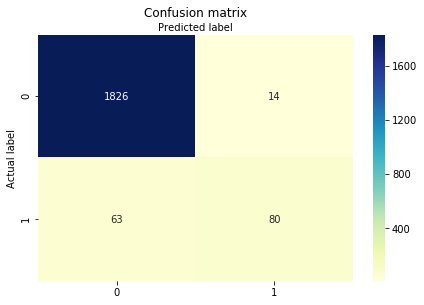

In [90]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [91]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9611699445284921
Precision: 0.851063829787234
Recall: 0.5594405594405595


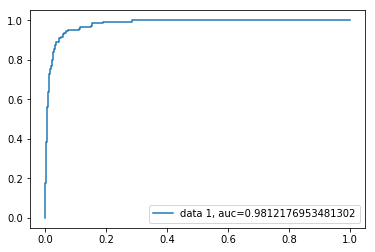

In [92]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# 2019 Oscar Best Picture Movie Prediction

## Two Contentant Lists:  2019 TMDB Top 20 list  and 2019 OMDB Top list


In [234]:
test_2019_df = pd.read_csv('./DataSources/test2019_tmdb.csv')
#test_2019_df = pd.read_csv('./DataSources/test2017_tmdb.csv')
test_2019_df.head()


,Unnamed: 0,id,budget,popularity,release_month,revenue,runtime,vote_average,vote_count,genre_weight,profit
0,0,338952,200000000,291.648,11,277290490,134,7.1,1377,0.066298,77290490
1,1,335983,116000000,283.450,10,508400000,112,6.5,2402,0.071429,392400000
2,2,507569,0,238.391,8,0,99,5.7,71,0.154301,0
3,3,353081,178000000,170.499,7,791017452,148,7.2,2355,0.121547,613017452
4,4,424694,52000000,158.986,10,384330487,135,8.2,1364,0.403315,332330487


In [235]:
test_2019_df

,Unnamed: 0,id,budget,popularity,release_month,revenue,runtime,vote_average,vote_count,genre_weight,profit
0,0,338952,200000000,291.648,11,277290490,134,7.1,1377,0.066298,77290490
1,1,335983,116000000,283.450,10,508400000,112,6.5,2402,0.071429,392400000
2,2,507569,0,238.391,8,0,99,5.7,71,0.154301,0
3,3,353081,178000000,170.499,7,791017452,148,7.2,2355,0.121547,613017452
4,4,424694,52000000,158.986,10,384330487,135,8.2,1364,0.403315,332330487
5,5,360920,75000000,163.686,11,0,90,6.2,158,0.192976,-75000000
6,6,404368,0,121.254,11,0,112,7.5,53,0.088003,0
7,7,439079,22000000,136.215,9,364943149,96,5.7,1561,0.126677,342943149
8,8,299536,300000000,121.664,4,2046239637,149,8.3,9544,0.154301,1746239637
9,9,458594,25000000,100.379,9,48818723,102,6.6,153,0.441989,23818723


In [236]:
x_pre_test = test_2019_df[numberic_features]
#x_pre_test = test_2019_omdb_df[numberic_features]

In [237]:

x_pre = x_pre_test.values
X_pre_scaled = preprocessing.scale(x_pre)

/Users/my_macbook/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [238]:
y_pred=logreg.predict(X_pre_scaled)

In [239]:
y_pro = model.predict_proba(X_pre_scaled)

In [240]:
y_pro

array([[9.99999985e-01, 1.54777088e-08],
       [9.99999919e-01, 8.13460281e-08],
       [9.99999898e-01, 1.01628064e-07],
       [9.98507009e-01, 1.49299112e-03],
       [8.17978536e-01, 1.82021464e-01],
       [9.99972732e-01, 2.72682464e-05],
       [9.63262424e-01, 3.67375756e-02],
       [9.98916709e-01, 1.08329121e-03],
       [3.32347929e-03, 9.96676521e-01],
       [9.44985082e-01, 5.50149184e-02],
       [9.98284267e-01, 1.71573320e-03],
       [7.78540506e-01, 2.21459494e-01],
       [7.59128540e-01, 2.40871460e-01],
       [9.97054799e-01, 2.94520147e-03],
       [8.89088436e-02, 9.11091156e-01],
       [5.47323158e-01, 4.52676842e-01],
       [9.89115036e-01, 1.08849637e-02],
       [9.94895327e-01, 5.10467315e-03],
       [9.83577800e-01, 1.64221995e-02],
       [9.94190710e-01, 5.80929003e-03]])

In [241]:
pro_ranking = []
for i in range(len(y_pro)):
    pro_ranking.append(y_pro[i][1])

In [242]:
#test_2019_omdb_df['pred_pro'] = pro_ranking
#test_2019_omdb_df = test_2019_omdb_df.sort_values(by=['pred_pro'],ascending=False)
#test_2019_omdb_df = test_2019_omdb_df.reset_index()
pre_logrege_df = test_2019_df
pre_logrege_df['pred_pro'] = pro_ranking
pre_logrege_df = pre_logrege_df.sort_values(by=['pred_pro'],ascending=False)
pre_logrege_df = pre_logrege_df.reset_index()
pre_logrege_df

,index,Unnamed: 0,id,budget,popularity,release_month,revenue,runtime,vote_average,vote_count,genre_weight,profit,pred_pro
0,8,8,299536,300000000,121.664,4,2046239637,149,8.3,9544,0.154301,1746239637,9.966765e-01
1,14,14,332562,36000000,101.953,10,340740907,135,7.4,1826,0.524862,304740907,9.110912e-01
2,15,15,369972,70000000,99.314,10,94140236,141,7.2,838,0.453039,24140236,4.526768e-01
3,12,12,260513,200000000,107.351,6,868429911,118,7.6,3844,0.159826,668429911,2.408715e-01
4,11,11,527435,0,90.337,11,0,104,7.3,114,0.160221,0,2.214595e-01
5,4,4,424694,52000000,158.986,10,384330487,135,8.2,1364,0.403315,332330487,1.820215e-01
6,9,9,458594,25000000,100.379,9,48818723,102,6.6,153,0.441989,23818723,5.501492e-02
7,6,6,404368,0,121.254,11,0,112,7.5,53,0.088003,0,3.673758e-02
8,18,18,463821,42000000,90.560,9,29950000,105,6.4,277,0.154301,-12050000,1.642220e-02
9,16,16,454293,29000000,95.617,9,33157615,111,6.3,238,0.093923,4157615,1.088496e-02


In [243]:
print('Oscar Best Picture Movie 2019 :Probability Ranking:\n')

title = []
prob = []

for i in range(len(pre_logrege_df)):
    id = int(pre_logrege_df.ix[i]['id'])
    detail_query_link = base_url1 + str(id) + '?' + api_key
    response = requests.get(detail_query_link).json()
    print(response['original_title'],pre_logrege_df.ix[i]['pred_pro'])
    title.append(response['original_title'])
    prob.append(pre_logrege_df.ix[i]['pred_pro'])

Oscar Best Picture Movie 2019 :Probability Ranking:

Avengers: Infinity War 0.9966765207131594
A Star Is Born 0.9110911563919819


/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.p

First Man 0.45267684224171223
Incredibles 2 0.24087145970195076
The Christmas Chronicles 0.22145949397186063
Bohemian Rhapsody 0.18202146434310856
Peppermint 0.055014918369839495
Ralph Breaks the Internet 0.036737575578081966
The House with a Clock in Its Walls 0.016422199536974266
Night School 0.010884963678115412
The Meg 0.0058092900281428465
The Girl in the Spider's Web 0.005104673147578552
The Equalizer 2 0.0029452014745635752
The Predator 0.0017157332034988379
Mission: Impossible - Fallout 0.0014929911229539774
The Nun 0.0010832912100375105
The Grinch 2.7268246429308265e-05
劇場版 七つの大罪 天空の囚われ人 1.0162806364557465e-07
Venom 8.13460281350915e-08
Fantastic Beasts: The Crimes of Grindelwald 1.5477708755203886e-08


In [244]:
winning_prediction = pd.DataFrame({'Title':title,'Probability Ranking':prob})

In [245]:
winning_prediction

,Title,Probability Ranking
0,Avengers: Infinity War,9.966765e-01
1,A Star Is Born,9.110912e-01
2,First Man,4.526768e-01
3,Incredibles 2,2.408715e-01
4,The Christmas Chronicles,2.214595e-01
5,Bohemian Rhapsody,1.820215e-01
6,Peppermint,5.501492e-02
7,Ralph Breaks the Internet,3.673758e-02
8,The House with a Clock in Its Walls,1.642220e-02
9,Night School,1.088496e-02


## Model 2:  XGBoost

In [246]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import plot_importance

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# load data
XGB_df = num_feature_df

# split data into X and y
Xg = XGB_df.drop(columns=['nominated']).as_matrix()
Yg = XGB_df['nominated'].as_matrix()
# split data into train and test sets
seed = 7
test_size = 0.33
Xg_train, Xg_test, yg_train, yg_test = train_test_split(Xg, Yg, test_size=test_size, random_state=seed)


# fit model on training data
model_xgb = XGBClassifier()



eval_set = [(Xg_test, yg_test)]
model_xgb.fit(Xg_train, yg_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)
model_xgb.fit(Xg_train, yg_train)

# make predictions for test data
yg_pred = model_xgb.predict(Xg_test)
predictions = [round(value) for value in yg_pred]
# evaluate predictions
accuracy = accuracy_score(yg_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-logloss:0.612987
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.546234
[2]	validation_0-logloss:0.491482
[3]	validation_0-logloss:0.443869
[4]	validation_0-logloss:0.40378
[5]	validation_0-logloss:0.368386
[6]	validation_0-logloss:0.337897
[7]	validation_0-logloss:0.311716
[8]	validation_0-logloss:0.288735
[9]	validation_0-logloss:0.268674
[10]	validation_0-logloss:0.250961
[11]	validation_0-logloss:0.234672
[12]	validation_0-logloss:0.220586
[13]	validation_0-logloss:0.207594
[14]	validation_0-logloss:0.195597
[15]	validation_0-logloss:0.185489
[16]	validation_0-logloss:0.176325
[17]	validation_0-logloss:0.168283
[18]	validation_0-logloss:0.160501
[19]	validation_0-logloss:0.154058
[20]	validation_0-logloss:0.147279
[21]	validation_0-logloss:0.141547
[22]	validation_0-logloss:0.136401
[23]	validation_0-logloss:0.13213
[24]	validation_0-logloss:0.127392
[25]	validation_0-logloss:0.123363
[26]	validation_0-logloss:0.119531

/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


[94]	validation_0-logloss:0.060139
[95]	validation_0-logloss:0.060123
[96]	validation_0-logloss:0.059946
[97]	validation_0-logloss:0.059754
[98]	validation_0-logloss:0.059473
[99]	validation_0-logloss:0.059262
Accuracy: 97.86%


In [247]:
print(model_xgb.feature_importances_)

[0.03020134 0.29194632 0.0385906  0.01174497 0.14932886 0.16442953
 0.1728188  0.06375839 0.07718121]


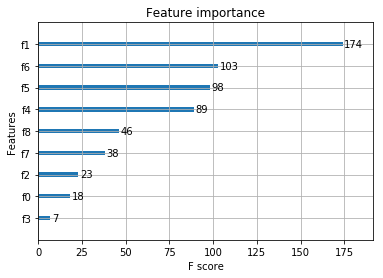

In [248]:
plot_importance(model_xgb)
plt.show()

## XGBoost Prediction

In [249]:
x_pre = x_pre_test.as_matrix()

y_pro_xgb = model_xgb.predict_proba(x_pre)


/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [250]:
y_pro_xgb

array([[9.9811274e-01, 1.8872630e-03],
       [9.9885494e-01, 1.1450901e-03],
       [9.9957675e-01, 4.2322982e-04],
       [9.9649459e-01, 3.5054001e-03],
       [9.7330165e-01, 2.6698334e-02],
       [9.9971884e-01, 2.8117761e-04],
       [9.9867386e-01, 1.3261354e-03],
       [9.9950016e-01, 4.9984653e-04],
       [8.4424579e-01, 1.5575421e-01],
       [9.9834937e-01, 1.6506251e-03],
       [9.9915951e-01, 8.4047718e-04],
       [9.9813175e-01, 1.8682567e-03],
       [9.9622834e-01, 3.7716473e-03],
       [9.9903047e-01, 9.6950575e-04],
       [9.9695921e-01, 3.0408145e-03],
       [9.9818450e-01, 1.8154850e-03],
       [9.9944907e-01, 5.5093289e-04],
       [9.9962306e-01, 3.7696335e-04],
       [9.9967915e-01, 3.2084319e-04],
       [9.9909633e-01, 9.0365257e-04]], dtype=float32)

In [251]:
pre_lxgboost_df = test_2019_df

pro_ranking = []
for i in range(len(y_pro_xgb)):
    pro_ranking.append(y_pro_xgb[i][1])

pre_lxgboost_df['pred_pro'] = pro_ranking
pre_lxgboost_df = pre_lxgboost_df.sort_values(by=['pred_pro'],ascending=False)
pre_lxgboost_df = pre_lxgboost_df.reset_index()
pre_lxgboost_df.head()

,index,Unnamed: 0,id,budget,popularity,release_month,revenue,runtime,vote_average,vote_count,genre_weight,profit,pred_pro
0,8,8,299536,300000000,121.664,4,2046239637,149,8.3,9544,0.154301,1746239637,0.155754
1,4,4,424694,52000000,158.986,10,384330487,135,8.2,1364,0.403315,332330487,0.026698
2,12,12,260513,200000000,107.351,6,868429911,118,7.6,3844,0.159826,668429911,0.003772
3,3,3,353081,178000000,170.499,7,791017452,148,7.2,2355,0.121547,613017452,0.003505
4,14,14,332562,36000000,101.953,10,340740907,135,7.4,1826,0.524862,304740907,0.003041


In [252]:
print('Oscar Best Picture Movie 2019 -XGBoost :Probability Ranking:\n')

title = []
prob = []

for i in range(len(pre_lxgboost_df)):
    id = int(pre_lxgboost_df.ix[i]['id'])
    detail_query_link = base_url1 + str(id) + '?' + api_key
    response = requests.get(detail_query_link).json()
    print(response['original_title'],pre_lxgboost_df.ix[i]['pred_pro'])
    title.append(response['original_title'])
    prob.append(pre_lxgboost_df.ix[i]['pred_pro'])

Oscar Best Picture Movie 2019 -XGBoost :Probability Ranking:

Avengers: Infinity War 0.1557542085647583
Bohemian Rhapsody 0.026698334142565727


/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.p

Incredibles 2 0.003771647345274687
Mission: Impossible - Fallout 0.003505400149151683
A Star Is Born 0.0030408145394176245
Fantastic Beasts: The Crimes of Grindelwald 0.0018872630316764116
The Christmas Chronicles 0.0018682567169889808
First Man 0.0018154849531129003
Peppermint 0.001650625141337514
Ralph Breaks the Internet 0.0013261353597044945
Venom 0.0011450900929048657
The Equalizer 2 0.0009695057524368167
The Meg 0.0009036525734700263
The Predator 0.000840477179735899
Night School 0.0005509328912012279
The Nun 0.0004998465301468968
劇場版 七つの大罪 天空の囚われ人 0.00042322982335463166
The Girl in the Spider's Web 0.00037696334766224027
The House with a Clock in Its Walls 0.00032084318809211254
The Grinch 0.00028117760666646063


In [253]:
winning_prediction_xgboost = pd.DataFrame({'Title':title,'Probability Ranking':prob})
winning_prediction_xgboost

,Title,Probability Ranking
0,Avengers: Infinity War,0.155754
1,Bohemian Rhapsody,0.026698
2,Incredibles 2,0.003772
3,Mission: Impossible - Fallout,0.003505
4,A Star Is Born,0.003041
5,Fantastic Beasts: The Crimes of Grindelwald,0.001887
6,The Christmas Chronicles,0.001868
7,First Man,0.001815
8,Peppermint,0.001651
9,Ralph Breaks the Internet,0.001326


# Ensemble Training

In [254]:
num_feature_df.columns

Index(['budget', 'popularity', 'release_month', 'revenue', 'runtime',
       'vote_average', 'vote_count', 'genre_weight', 'profit', 'nominated'],
      dtype='object')

In [255]:

train_db_df = num_feature_df
train_db_df.head()

,budget,popularity,release_month,revenue,runtime,vote_average,vote_count,genre_weight,profit,nominated
1,300000000,139.082615,5,961000000,169.0,6.9,4500,0.106223,661000000,0
2,245000000,107.376788,10,880674609,148.0,6.3,4466,0.134120,635674609,0
3,250000000,112.312950,7,1084939099,165.0,7.6,9106,0.515021,834939099,0
4,260000000,43.926995,3,284139100,132.0,6.1,2124,0.094421,24139100,0
5,258000000,115.699814,5,890871626,139.0,5.9,3576,0.106223,632871626,0


In [256]:
train_db_df.fillna(0) 

from sklearn.utils import shuffle
train_db_df = shuffle(train_db_df)

In [257]:
train_db_df= train_db_df.fillna(0) 
train_db_df.head()

,budget,popularity,release_month,revenue,runtime,vote_average,vote_count,genre_weight,profit,nominated
2375,18000000,32.717853,2,6212282,112.0,6.2,694,0.422747,-11787718,0
2474,25000000,6.091033,12,0,139.0,6.4,76,0.572961,-25000000,0
3834,3500000,10.219942,5,12600000,116.0,7.1,158,0.502146,9100000,0
4454,0,5.870319,5,0,88.0,6.9,103,0.447425,0,0
3105,10000000,2.852830,9,0,111.0,6.3,29,0.447425,-10000000,0


In [258]:
ix_ran = train_db_df.index.values
np.random.shuffle(ix_ran)

df_len = len(train_db_df)
train_len = int(df_len * 0.8)  


ix_train = ix_ran[:train_len]
ix_valid = ix_ran[train_len:]

df_train = train_db_df.ix[ix_train]
df_valid = train_db_df.ix[ix_valid]

print(len(ix_train))
print(len(ix_valid))

3964
992


/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()
/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


In [259]:
df_train.head()
len(df_train[df_train['nominated'] == 1])
len(df_valid[df_valid['nominated'] == 1])

70

In [260]:
df_train = df_train.fillna(0)
df_valid = df_valid.fillna(0)
df_train.tail()

,budget,popularity,release_month,revenue,runtime,vote_average,vote_count,genre_weight,profit,nominated
263,15000000,7.297757,8,30127963,115.0,6.3,130,0.365880,15127963,0
3624,90000000,19.224754,6,102000000,93.0,5.4,334,0.129828,12000000,0
2434,40000000,47.649554,7,126248813,107.0,6.0,1206,0.155579,86248813,0
1303,12000000,22.708647,2,6814789,97.0,5.9,386,0.449571,-5185211,0
3672,65000000,31.324734,1,71154592,92.0,5.0,687,0.064378,6154592,0


In [261]:
train_col = ['budget', 'popularity', 'release_month', 'revenue', 'runtime','vote_average', 'vote_count', 'genre_weight', 'profit']

In [262]:
from sklearn import preprocessing
X= df_train.drop(columns=['nominated']).values
X = X[~np.isnan(X).any(axis=1)]
X_scaled = preprocessing.scale(X)

/Users/my_macbook/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [263]:
X= df_train[train_col].values
Y = df_train['nominated'].values
clf =  LogisticRegression(C=1e5, class_weight={0:1, 1:4000}, n_jobs=3)
clf.fit(X,Y)
y_p=clf.predict_proba(X)

/Users/my_macbook/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/my_macbook/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 3.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [264]:
y_p

array([[2.56960463e-02, 9.74303954e-01],
       [1.77668890e-02, 9.82233111e-01],
       [1.11490031e-01, 8.88509969e-01],
       ...,
       [4.20953272e-10, 1.00000000e+00],
       [6.03822533e-02, 9.39617747e-01],
       [5.70715986e-09, 9.99999994e-01]])

In [265]:
params_0 = {'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 3, 'learning_rate': 0.01}
params_1 = {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 5, 'class_weight' : {0:1, 1:4000}, 'n_jobs':5}

scaler = StandardScaler()
    
clfs = [
    LogisticRegression(C=1e5,class_weight={0:1, 1:4000}, n_jobs=3),
    
    GaussianNB(),

    ensemble.RandomForestClassifier(**params_1),

    ensemble.ExtraTreesClassifier(**params_1),
    
    ensemble.GradientBoostingClassifier(**params_0)
    
    ]

In [266]:
X_train = df_train[train_col].values

y_train = df_train['nominated'].values
    
X_train = scaler.fit_transform(X_train)

X_valid = df_valid[train_col].values
y_valid = df_valid['nominated'].values
X_valid_x= scaler.transform(X_valid)

In [267]:
prob_result = []
df_m = []
clfs_fited = []
for clf in clfs:
    print("%s:" %  clf.__class__.__name__)
    clf.fit(X_train,y_train)
    clfs_fited.append(clf)
    y_pred = clf.predict(X_valid_x)
    prob_pos  = clf.predict_proba(X_valid_x)[:, 1]
    prob_result.append(prob_pos)
    m = confusion_matrix(y_valid, y_pred)
    clf_score = brier_score_loss(y_valid, prob_pos, pos_label=y_valid.max())
    print("\tBrier: %1.5f" % (clf_score))
    print("\tPrecision: %1.5f" % precision_score(y_valid, y_pred))
    print("\tRecall: %1.5f" % recall_score(y_valid, y_pred))
    print("\tF1: %1.5f" % f1_score(y_valid, y_pred))
    print("\tauc: %1.5f" % roc_auc_score(y_valid, prob_pos))
    print("\tAccuracy: %1.5f\n" % accuracy_score(y_valid, y_pred))
    df_m.append(
        pd.DataFrame(m, index=['True Negative', 'True Positive'], columns=['Pred. Negative', 'Pred. Positive'])
        )


LogisticRegression:
	Brier: 0.20732
	Precision: 0.21101
	Recall: 0.98571
	F1: 0.34761
	auc: 0.97222
	Accuracy: 0.75286

GaussianNB:
	Brier: 0.03347
	Precision: 0.76923
	Recall: 0.42857
	F1: 0.55046
	auc: 0.96614
	Accuracy: 0.95324

RandomForestClassifier:


/Users/my_macbook/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/my_macbook/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 3.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


	Brier: 0.14802
	Precision: 0.24275
	Recall: 0.95714
	F1: 0.38728
	auc: 0.96574
	Accuracy: 0.79771

ExtraTreesClassifier:
	Brier: 0.35263
	Precision: 0.11616
	Recall: 0.98571
	F1: 0.20783
	auc: 0.95397
	Accuracy: 0.49809

GradientBoostingClassifier:
	Brier: 0.02806
	Precision: 0.93023
	Recall: 0.57143
	F1: 0.70796
	auc: 0.95439
	Accuracy: 0.96851



In [268]:
feature_importance = clfs_fited[2].feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

In [269]:
feature_importance[sorted_idx]

array([  1.77355923,   2.16823117,   2.50671708,   8.03599953,
        18.14438359,  21.48945164,  30.81448271,  88.96642394,
       100.        ])

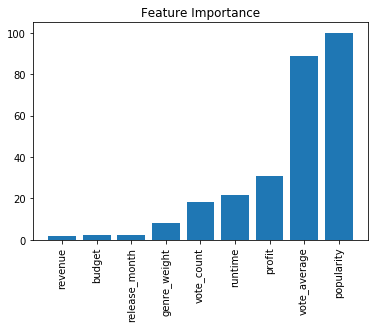

In [270]:
features = [train_col[ix] for ix in sorted_idx]
bardata = {"name":features[::-1], "importance percent":feature_importance[sorted_idx][::-1]}
# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), feature_importance[sorted_idx])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), features, rotation=90)

# Show plot
plt.show()

# Prediction

In [271]:
x_pre = x_pre_test.as_matrix()
y_p_en=clfs[1].predict_proba(x_pre)

/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [272]:
print('Ensemble model:ExtraTreesClassifier')
y_p_en_etree=clfs[3].predict_proba(x_pre)



pro_ranking = []
for i in range(len(y_pro)):
    pro_ranking.append(y_p_en_etree[i][1])


Ensemble model:ExtraTreesClassifier


In [273]:
y_p_en_gb=clfs[0].predict(x_pre)
y_p_en_gb

array([0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])

In [274]:
ensemble_name = ['LogisticRegression','GaussianNB']#,'RandomForestClassifier','ExtraTreesClassifier','GradientBoostingClassifier']
for ensemble_index in range(len(ensemble_name)):
    print('Ensemble model:',ensemble_name[ensemble_index])
    y_p_en=clfs[ensemble_index].predict_proba(x_pre)
    print(y_p_en)
    for i in range(len(y_p_en)):
        if (y_p_en[i][1] == 1):
            best_picture_tmdb_id = int(test_2019_df.ix[i].id)
            detail_query_link = base_url1 + str(best_picture_tmdb_id) + '?' + api_key
            response = requests.get(detail_query_link).json()
            print('best picture:',response['title'])

        

Ensemble model: LogisticRegression
[[1.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [1.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [1.00000000e+000 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [1.00000000e+000 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000]
 [1.00000000e+000 1.30216362e-288]
 [0.00000000e+000 1.00000000e+000]
 [1.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [1.00000000e+000 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000]]
best picture: Venom


/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


best picture: Mission: Impossible - Fallout
best picture: Bohemian Rhapsody
best picture: The Nun
best picture: Avengers: Infinity War
best picture: Incredibles 2
best picture: A Star Is Born
Ensemble model: GaussianNB
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
best picture: Fantastic Beasts: The Crimes of Grindelwald


/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


best picture: Venom
best picture: Mission: Impossible - Fallout
best picture: Bohemian Rhapsody
best picture: The Grinch
best picture: The Nun
best picture: Avengers: Infinity War
best picture: Peppermint
best picture: The Predator
best picture: Incredibles 2
best picture: The Equalizer 2
best picture: A Star Is Born
best picture: First Man
best picture: Night School
best picture: The Girl in the Spider's Web
best picture: The House with a Clock in Its Walls
best picture: The Meg


# 2018 Movie Analysis 

## 1. The highest revenues Movies in 2018 

In [278]:
#2018 the highest revenues Movies

discovery_link = 'https://api.themoviedb.org/3/discover/movie?'
query_release_year = '&primary_release_year='
rev_sort_by = '&sort_by=revenue.desc'
rev_2018_query_link = discovery_link + api_key + query_release_year + '2018' + rev_sort_by

high_rev_2018 = requests.get(rev_2018_query_link).json()






In [279]:
high_rev_2018_result = high_rev_2018['results']


In [280]:
movie_rev_list = []
movie_title_list = []

for movie in high_rev_2018_result:
    tmdb_id = str(movie['id']) + '?'
    detail_query_link = base_url1 + tmdb_id + api_key 
    response = requests.get(detail_query_link).json()
    movie_rev_list.append(response['revenue'])
    movie_title_list.append(response['title'])



In [281]:
columns = ['Name','Revenue']
rev_ranking2018_df = pd.DataFrame(columns=columns)

rev_ranking2018_df['Name'] =pd.Series(movie_title_list).values

rev_ranking2018_df['Revenue'] =pd.Series(movie_rev_list).values



In [282]:
rev_ranking2018_df= rev_ranking2018_df.set_index('Name')

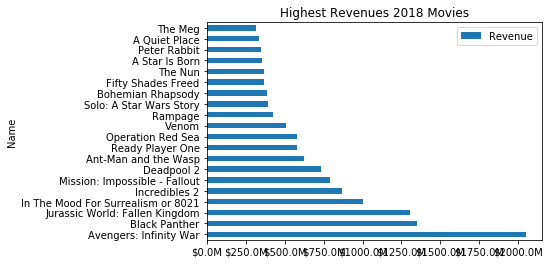

In [283]:
fig, ax = plt.subplots()

def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x*1e-6)
formatter = FuncFormatter(millions)
ax.xaxis.set_major_formatter(formatter)


rev_ranking2018_df.plot(kind = 'barh',ax=ax, title = 'Highest Revenues 2018 Movies')
fig.savefig('2018highrev.png')


## 2. 2018 Movie Popularity Ranking 

In [284]:
pop_sort_by = '&sort_by=popularity.desc'
pop_2018_query_link = discovery_link + api_key + query_release_year + '2018' + pop_sort_by

high_pop_2018 = requests.get(pop_2018_query_link).json()



In [285]:
high_pop_2018

{'page': 1,
 'total_results': 12390,
 'total_pages': 620,
 'results': [{'vote_count': 2441,
   'id': 335983,
   'video': False,
   'vote_average': 6.5,
   'title': 'Venom',
   'popularity': 368.719,
   'poster_path': '/2uNW4WbgBXL25BAbXGLnLqX71Sw.jpg',
   'original_language': 'en',
   'original_title': 'Venom',
   'genre_ids': [878],
   'backdrop_path': '/VuukZLgaCrho2Ar8Scl9HtV3yD.jpg',
   'adult': False,
   'overview': 'Eddie Brock is a reporter, investigating people who want to go unnoticed. But after he makes a terrible discovery at the Life Foundation, he begins to transform into ‘Venom’.  The Foundation has discovered creatures called symbiotes, and believes they’re the key to the next step in human evolution. Unwittingly bonded with one, Eddie discovers he has incredible new abilities - and a voice in his head that’s telling him to embrace the darkness.  One of Marvel’s most celebrated anti-heroes comes to the big screen in ‘Venom’, starring Tom Hardy, Michelle Williams and Riz 

In [286]:
high_pop_2018_result = high_pop_2018['results']



In [287]:
high_pop_2018_result

[{'vote_count': 2441,
  'id': 335983,
  'video': False,
  'vote_average': 6.5,
  'title': 'Venom',
  'popularity': 368.719,
  'poster_path': '/2uNW4WbgBXL25BAbXGLnLqX71Sw.jpg',
  'original_language': 'en',
  'original_title': 'Venom',
  'genre_ids': [878],
  'backdrop_path': '/VuukZLgaCrho2Ar8Scl9HtV3yD.jpg',
  'adult': False,
  'overview': 'Eddie Brock is a reporter, investigating people who want to go unnoticed. But after he makes a terrible discovery at the Life Foundation, he begins to transform into ‘Venom’.  The Foundation has discovered creatures called symbiotes, and believes they’re the key to the next step in human evolution. Unwittingly bonded with one, Eddie discovers he has incredible new abilities - and a voice in his head that’s telling him to embrace the darkness.  One of Marvel’s most celebrated anti-heroes comes to the big screen in ‘Venom’, starring Tom Hardy, Michelle Williams and Riz Ahmed.',
  'release_date': '2018-10-03'},
 {'vote_count': 1473,
  'id': 338952,
  

In [288]:
high_pop_2018_result[1]['popularity']

315.827

In [289]:
movie_pop_list = []
movie_title_list = []

for i in range(len(high_pop_2018_result)):
    movie_pop_list.append(high_pop_2018_result[i]['popularity'])
    movie_title_list.append(high_pop_2018_result[i]['title'])



In [290]:
columns = ['Name','popularity']
rate_ranking2018_df = pd.DataFrame(columns=columns)

rate_ranking2018_df['Name'] =pd.Series(movie_title_list).values

rate_ranking2018_df['popularity'] =pd.Series(movie_pop_list).values

rate_ranking2018_df= rate_ranking2018_df.set_index('Name')

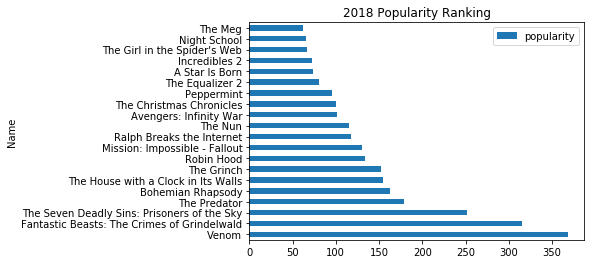

In [291]:
rate_ranking2018_df.plot(kind = 'barh',title ='2018 Popularity Ranking')

fig.savefig('2018pop.png')

In [ ]:
rate_ranking2018_df.reset_index()
rate_ranking2018_df.to_csv('./DataSources/rate2018_tmdb.csv')